## Fig. 1. Phase-plane structure and linear stability of the firing-rate equations.
### A.
Single-population FREs are bistable.  
### B.
Eigenvalue spectrum of the Jacobian at the focus.  
### C.
Eigenvalue spectrum of the Jacobian at the node.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
from scipy.linalg import eig
from scipy.interpolate import interp1d

In [3]:
# config for plotting.
config = {
        'font.family' : 'sans-serif',
        'font.size' : 12.0,
        'xtick.direction' : 'in',
        'ytick.direction' : 'in',
        'axes.xmargin' : 0.1,
        'axes.ymargin' : 0.11,
        'axes.linewidth' : 1.0,
        'axes.titlelocation' : 'left',
        'axes.titleweight' : 'bold',
        'lines.linewidth' : 0.7,
        'legend.fancybox' : False,
        'legend.loc' : 'upper right'
    }
plt.rcParams.update(config)
# label = ['(' + chr(ord("a")+i) + ')' for i in range(26)]
savedir = 'fig1/'
os.makedirs(savedir, exist_ok=True)

In [4]:
def fre_single(t, y, J, eta, delta, I = lambda t: 0):
    '''
        firing-rate equation for single population.
    '''
    r, v = y
    dr = 2 * r * v + delta / np.pi
    dv = v**2 + J * r + eta - (np.pi * r) ** 2 + I(t)
    return np.array([dr, dv])

def fre_single_jacobian(t, y, J, eta, delta):
    '''
        Jacobian matrix of fre_single.
    '''
    r, v = y
    A = np.array([[2 * v, 2 * r], [J - 2 * np.pi**2 * r, 2 * v]])
    return A

def fre_network(t, y, w, eta, delta, P, I = lambda t: 0):
    '''
        firing-rate equation for network of P populations.
    '''
    dy = np.zeros(P * 2)
    dy[:P] = 2 * y[:P] * y[P:] + delta / np.pi # r_k
    dy[P:] = y[P:]**2 + w @ y[:P] + eta - (np.pi * y[:P]) ** 2 + I(t)# v_k
    return dy

def fre_seq(t, y, J1, J2, eta, delta, P, I = lambda t: 0, global_inhibition = True):
    '''
        firing-rate equation for sequential memory.
        J1 : connection between (k-1) -> k
        J2 : recurrent connection between k -> k
        note that J2 corresponds to J in fre_single.
    '''
    w = J1 * np.roll(np.eye(P), 1, axis = 0)  + J2 * np.eye(P) - (J1/P) * global_inhibition * np.ones((P, P), dtype = 'float') # J1/Pを(J1 + J2)/P に変更する必要があるかもしれない

    dy = fre_network(t, y, w, eta, delta, P, I)
    return dy
def fre_single_inverse(t, y, J, eta, delta, I = lambda t: 0):
    return -fre_single(t, y, J, eta, delta, I)


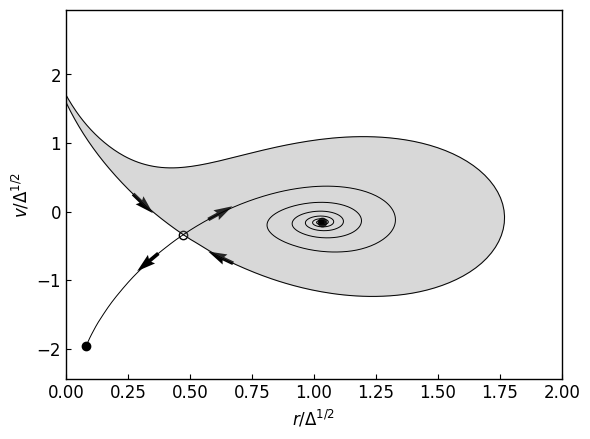

In [5]:
# parameters for single population
J2 = 15; eta = -5; delta = 1.0
t0 = 0; t1 = 100
t_eval = np.linspace(t0, t1, 10000)
# compute fixed points
focus = root(lambda y : fre_single(0, y, J2, eta, delta), [[1, 0]]).x
node = root(lambda y : fre_single(0, y, J2, eta, delta), [[0, -2]]).x
saddle = root(lambda y : fre_single(0, y, J2, eta, delta), [[0.5, -0.5]]).x

plt.scatter(*focus, c = 'k', label = 'focus')
plt.scatter(*node, c = 'k', label = 'node')
plt.scatter(*saddle, c = 'w', edgecolor = 'k', label = 'saddle')

w, v = eig(fre_single_jacobian(0, saddle, J2, eta, delta))
v_m = v[:, w<0].flatten() # eigenvalue < 0
v_p = v[:, w>0].flatten() # eigenvalue > 0
sol1 = solve_ivp(fre_single, (t0, t1), saddle + v_p * 1e-5, args = (J2, eta, delta), t_eval=t_eval)
sol2 = solve_ivp(fre_single, (t0, t1), saddle - v_p * 1e-5, args = (J2, eta, delta), t_eval=t_eval)
sol3 = solve_ivp(fre_single_inverse, (t0, t1), saddle + v_m * 1e-5, args = (J2, eta, delta), t_eval=t_eval)
sol4 = solve_ivp(fre_single_inverse, (t0, t1), saddle - v_m * 1e-5, args = (J2, eta, delta), t_eval=t_eval)

for i, sol in enumerate([sol1, sol2, sol3, sol4]):
    plt.plot(sol.y[0], sol.y[1], c = 'k')
    if i <= 1:
        idx = np.argmax(np.abs(sol.y[0] - saddle[0]) > 0.1)
    else:
        idx = np.argmax(np.abs(sol.y[0] - saddle[0]) > 0.2)
    r, v = sol.y[:, idx]
    dr, dv = fre_single(sol.t[idx], [r, v], J2, eta, delta)
    plt.quiver(r, v, dr, dv, angles = 'xy')
r = np.append(sol3.y[0], sol4.y[0][::-1]) # XXX : なんで[::-1]が必要なのかは十分に理解しているわけではない...
v = np.append(sol3.y[1], sol4.y[1][::-1])
plt.fill(r, v, alpha = 0.3, c = 'gray')
# plt.title('phase plane of single population')
plt.xlabel(r'$r/\Delta^{1/2}$')
plt.ylabel(r'$v/\Delta^{1/2}$')
plt.xlim(0, 2.0)
plt.savefig(savedir + 'phase_plane_single.pdf', bbox_inches = 'tight', )
plt.show()


In [6]:
def eig_vals_theory(fp, J1, J2, P):
    r, v = fp
    # 1のP乗根
    xi = np.exp(2j * np.pi * np.arange(P) / P)
    xi[0] = 0
    eigenvalues_pos = 2*v + np.sqrt(
        2 * r * (J1 * xi + J2 - 2 * np.pi**2 * r)
    )
    eignevalues_neg = 2*v - np.sqrt(
        2 * r * (J1 * xi + J2 - 2 * np.pi**2 * r)
    )
    eigenvalues = np.concatenate([eigenvalues_pos, eignevalues_neg])
    return eigenvalues
def eig_vals_infty(fp, J1, J2):
    P = 500
    r, v = fp
    # 1のP乗根
    xi = np.exp(2j * np.pi * np.arange(P) / P)
    xi[0] = 0
    eigenvalues_pos = 2*v + np.sqrt(
        2 * r * (J1 * xi + J2 - 2 * np.pi**2 * r)
    )
    eignevalues_neg = 2*v - np.sqrt(
        2 * r * (J1 * xi + J2 - 2 * np.pi**2 * r)
    )
    eigenvalues = np.concatenate([eigenvalues_pos, eignevalues_neg])
    return eigenvalues
    
# parameters for P populations
J1 = 15; P = 8
for fp in [node, focus]:
    # compute jacobian around the fixed point
    jac_single = fre_single_jacobian(0, fp, J2, eta, delta)
    jac = np.kron(np.eye(P), jac_single) 
    jac += np.kron(np.roll(np.eye(P), 1, axis = 0), np.array([[0, 0], [J1, 0]]))
    jac -= np.kron(np.ones((P, P)), np.array([[0, 0], [J1/P, 0]])) 

    vals, vecs = eig(jac)
    plt.scatter(vals.real, vals.imag,c s= 'b')

    # eigenspectrum in the limit of P -> inf
    val_theory = eig_vals_infty(fp, J1, J2)
    plt.scatter(val_theory.real, val_theory.imag, c = 'grey', marker = '.', s = 0.01)
    plt.axvline(0, ls = '--', c = 'k')
    plt.xlabel(r'$\mathrm{Re} \lambda$')
    plt.ylabel(r'$\mathrm{Im} \lambda$')
    fig_title = 'eignespectrum_' + ('node' if np.all(fp == node) else 'focus')
    plt.savefig(savedir + fig_title + '.pdf', bbox_inches = 'tight')
    print('eigenspectrum at' + (' node' if np.all(fp == node) else ' focus'))
    plt.show()


SyntaxError: invalid syntax (672905234.py, line 39)